# Visualize the basic demographics before mathcing and recalculate power based on QC results
This is the notebook for matching the control subjects with our ET subjects to creat new cohort to achieve 0.9 power for this study. 
## Data: 
    - 1. Freesurfer results: ICV. Lh/Rh_cerebellum_gm/wm (generated by "collect_volumes.sh" script);
        - Left/ Right cerebellum gray/white matter volumes 
    - 2. Cerebellar SUIT segmentation with SUIT and MDTB atlas; 
         - SUIT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;
         - MBTB: MDTB functional regions 1,2,4,5;
    - 3. Cerebellar MAGeTBrain [MAGeTBrain pipeline](https://github.com/CobraLab/documentation/wiki/MAGeTBrain#collecting-volumes)
        - MAGeT: Vermis VI, Vermis_CrusI,  Vermis_CrusII, CrusI, CrusII, Dentate nucleus;

## Cohorts
- Current cohort: MNI ET/NC (38/32, PPMI NC (116) and ADNI NC(308), QC information needed.

## Tasks
- Compare total cerebellar volumes (left and right)
- Compare lobule volumes (13 per hemisphere)

## Covariates
- Age, Sex, site, eTIV

In [1]:
## read tabular data of demographics and re-format for latter analysis
from pathlib import Path
import nipype.interfaces.io as nio
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('/codes')
# read tabular data
data_dir = Path("/codes/tab_data")
data_all_file = data_dir/'all_Des-cere_preped_qcInfo.csv'
data_DKT_file = data_dir/'all_DKT-cere_preped_qcInfo.csv'

data_df = pd.read_csv(data_all_file , sep=',', header=0, index_col=0);
DKT_df  = pd.read_csv(data_DKT_file , sep=',', header=0, index_col=0);

# figure save dir
fig_sv_dir = Path("/codes/stats/")
matched_des_file = data_dir/'matched_Des-cere_qced.csv'
matched_DKT_file = data_dir/ 'matched_DKT-cere_qced.csv'

# prepare Cerebellar lobules lists
SUIT_labels = ['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels = ['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels = ['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];
MDTB_labels   = ['MDTB_'+str(x+1) for x in range(10)];

## covariates and target labels
demo_list=['age','sex','group', 'cohort','site','eTIV','SupraTentorialVol', 'SupraTentorialVolNotVent','InfraTentorialVol']
cerebellum_list = ['Left_Cerebellum_Cortex','Left_Cerebellum_White_Matter',
                   'Right_Cerebellum_Cortex','Right_Cerebellum_White_Matter',
                   'Cerebellum_Cortex','Cerebellum_White_Matter'];
lobular_list = ['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 
                'Left_CrusI', 'Right_CrusI', 'Left_CrusII', 'Right_CrusII','Left_Dentate', 'Right_Dentate',
                'MDTB_1', 'MDTB_2', 'MDTB_4', 'MDTB_5'];

#multiple comparison correction columne
df_n_comp=pd.DataFrame(zip(cerebellum_list+lobular_list, [4,4,4,4,2,2, 9,9,9,9,9,9,9,9,9, 4,4,4,4]), 
                       index=cerebellum_list+lobular_list, columns=['ROI','n_comp'])

# Applying QC: 1. ET: 38 -> 34; 2. NC: 32 -> 29; 3. ADNI: 309 -> 223; 4. PPMI: 116 -> 78;
qc_th=2
curr_df = data_df.copy()
df_all_qc=curr_df[(curr_df['freesurfer_score']>=qc_th)&(curr_df['suit_score']>=qc_th)&(curr_df['maget_score']>=qc_th)]
curr_df = DKT_df.copy()
df_DKT_qc=curr_df[(curr_df['freesurfer_score']>=qc_th)&(curr_df['suit_score']>=qc_th)&(curr_df['maget_score']>=qc_th)]
# Select the data
tar_list = demo_list
match_df = df_all_qc[demo_list].copy()

220228-23:25:11,256 nipype.utils WARNING:
	 A newer version (1.7.0) of nipy/nipype is available. You are using 1.5.0


In [2]:
### statistical evaluation for group age and sex differences
from utils_.utils import age_sex_comp_test
mni_et_df  = match_df[(match_df['cohort']=='MNI')&(match_df['group']=='ET')].copy()
mni_nc_df  = match_df[(match_df['cohort']=='MNI')&(match_df['group']=='NC')].copy()
ppmi_nc_df = match_df[(match_df['cohort']=='PPMI')&(match_df['group']=='NC')].copy()
adni_nc_Df = match_df[(match_df['cohort']=='ADNI')&(match_df['group']=='NC')].copy()
all_nc_df  = match_df[(match_df['group']=='NC')].copy()
other_nc_df = match_df[(match_df['cohort']!='MNI')&(match_df['group']=='NC')].copy()

# Bebore matching
print("Before matching, test sex and age distribution for ET/all NC:")
age_sex_comp_test(mni_et_df, all_nc_df)
print("\nBefore matching, test sex and age distribution for ET/NC of MNI:")
age_sex_comp_test(mni_et_df, mni_nc_df)
print("Before matching, test sex and age distribution for ET/NC of PPMI:")
age_sex_comp_test(mni_et_df, ppmi_nc_df)
print("Before matching, test sex and age distribution for ET/NC of ADNI:")
age_sex_comp_test(mni_et_df, adni_nc_Df)

Before matching, test sex and age distribution for ET/all NC:
ET / NC  :
M/F:  26 / 8 ;  173 / 157
age mean:  73.73529411764706 / 70.96060606060605
age std:  7.254293706736771 / 13.351967613249064
Sex Chisqure test: 
 chisq =6.254503, pvalue = 0.012388
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =1.192710, pvalue = 0.233764, df = 362 



Before matching, test sex and age distribution for ET/NC of MNI:
ET / NC  :
M/F:  26 / 8 ;  18 / 11
age mean:  73.73529411764706 / 55.03448275862069
age std:  7.254293706736771 / 10.857791009950576
Sex Chisqure test: 
 chisq =0.933215, pvalue = 0.334029
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =8.141088, pvalue = 0.000000, df = 61 


Before matching, test sex and age distribution for ET/NC of PPMI:
ET / NC  :
M/F:  26 / 8 ;  47 / 31
age mean:  73.73529411764706 / 60.67948717948718
age std:  7.254293706736771 / 11.420525597729945
Sex Chisqure test: 
 chisq =2.074915, pvalue = 0.149738
Age 2-sided independent t-test (tstat,

{'sex': [8.205650388819329, 0.004176013725434352],
 'age': [-1.6099832592336414, 0.10863869098350716, 255.0]}

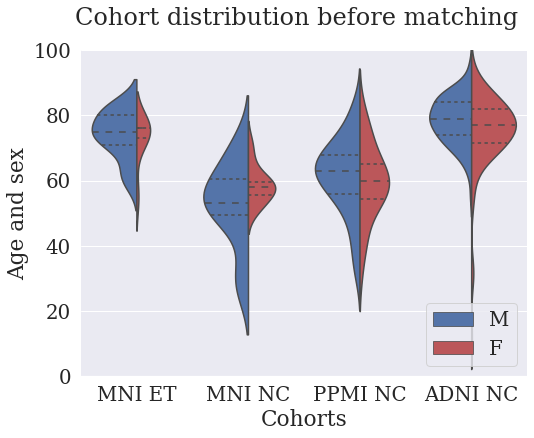

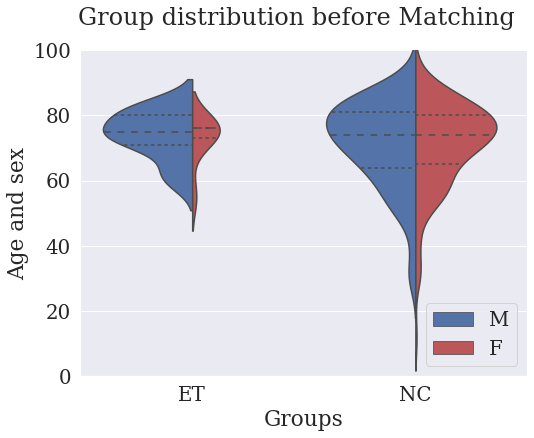

In [3]:
# visualziation for cohort age/sex distributions
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.8)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

GROUP_ORDER=['MNI ET','MNI NC','PPMI NC','ADNI NC']; SEX_ORDER=['M','F']; 
LIM_AGE=(0, 100); LIM_CNT=(0, 40); 

distr_vis_df = match_df.copy()
distr_vis_df.loc[:,'cohort group']=distr_vis_df.loc[:,'cohort']+' '+distr_vis_df.loc[:,'group'];

# Nested violinplot for cohort-group pairs distribution
f1, ax1 = plt.subplots(figsize=(8, 6))
ax1=sns.violinplot(data=distr_vis_df, x="cohort group", y="age", hue="sex",
                   split=True, inner="quartile",  scale='count', bw='silverman', orient='v',
                   order=GROUP_ORDER, hue_order=SEX_ORDER, 
                   linewidth=1.5, saturation=0.85, palette= ["b", "r"])

sns.despine(left=True)
ax1.set(ylim=LIM_AGE); 
ax1.set(xlabel="Cohorts"); 
ax1.set(ylabel="Age and sex"); 
plt.legend(loc='lower right')
f1.suptitle('Cohort distribution before matching',fontsize=24)
f1.savefig(fig_sv_dir / "cohort_beforeMatching.jpg", dpi=300)

# Nested violinplot for group pairs distribution
f2, ax2 = plt.subplots(figsize=(8, 6))

ax2=sns.violinplot(data=distr_vis_df, x="group", y="age", hue="sex",
                          split=True, inner="quartile",  scale='count', bw='silverman', orient='v',
                          order=['ET', 'NC'], hue_order=SEX_ORDER, 
                          linewidth=1.5, saturation=0.85, palette= ["b", "r"])
sns.despine(left=True)
ax2.set(ylim=LIM_AGE); 
ax2.set(xlabel="Groups"); 
ax2.set(ylabel="Age and sex"); 
plt.legend(loc='lower right')
f2.suptitle('Group distribution before Matching',fontsize=24)
f2.savefig(fig_sv_dir / "group_beforeMatching.jpg", dpi=300)

# matching Based on L2 distance: 
1. Recalculate power based on datasets after QC; 
2. Matching with L2 distance
    Ref: Spiel, C. et al. A Euclidean Distance-Based Matching Procedure for Nonrandomized Comparison Studies. European 468 Psychologist 13, 180–187 (2008).

In [4]:
# recalculate the power and number of subjects needed
from statsmodels.stats import power
import math
from numpy import array
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

# Before QC: n_et=38; n_nc=32;
n_et=len(match_df[(match_df['cohort']=='MNI')&(match_df['group']=='ET')])
n_nc=len(match_df[(match_df['cohort']=='MNI')&(match_df['group']=='NC')])

effect_size_expected=0.61; alpha_expected=0.05; power_expected=0.9;

# borrow controls from PPMI to achieve better power and median of literature effect size
print('1. Number of Controls needed (in total) for 1-sided test, at alpha='+str(alpha_expected)+', power='+str(power_expected)+' and effect size='+str(effect_size_expected)+': ')
r_1sided_expected=power.tt_ind_solve_power(effect_size=effect_size_expected, nobs1=n_et, alpha=alpha_expected, power=power_expected, ratio=None, alternative='larger')
n_nc_1sided_needed = math.ceil(r_1sided_expected*n_et)
print(' Total nc needed: ',  n_nc_1sided_needed, ', r=', r_1sided_expected, ' , total samples needed:',n_nc_1sided_needed+n_et)
#G-power results: 84
print('2. Number of Controls needed (in total) for 2-sided tests, for alpha='+str(alpha_expected)+', power='+str(power_expected)+' and effect size='+str(effect_size_expected)+': ')
r_2sided_expected=power.tt_ind_solve_power(effect_size=effect_size_expected, nobs1=n_et, alpha=alpha_expected, power=power_expected, ratio=None, alternative='two-sided')
n_nc_2sided_needed = math.ceil(r_2sided_expected*n_et)
print('Total nc needed: ',  n_nc_2sided_needed, ', r=', r_2sided_expected, ' , total samples needed:',n_nc_2sided_needed+n_et)
#G-power results: 236

1. Number of Controls needed (in total) for 1-sided test, at alpha=0.05, power=0.9 and effect size=0.61: 
 Total nc needed:  75 , r= 2.1812496668628913  , total samples needed: 109
2. Number of Controls needed (in total) for 2-sided tests, for alpha=0.05, power=0.9 and effect size=0.61: 
Total nc needed:  177 , r= 5.183050420216614  , total samples needed: 211


In [5]:
# matching by L2 distance
import math
from utils_.utils import age_sex_comp_test, dist_score_L2
# originally: nc_needed=116;
nc_needed=max(n_nc_1sided_needed, n_nc_2sided_needed)

def distr_match(distr_target, n_target, distr_source, match_method, para):
    #inlcuding all the subjects within the percentile of target distribution,
    import pandas as pd
    # parameters parsing
    percent_th = para['percentile']; percent_th_c = 100-para['percentile']; 
    ## calculating the expected number of matched subjects 
    distr_source.loc[:,'sub_id']=distr_source.index;
    res=distr_source;
    distr_target_m = distr_target[distr_target['sex']=='M'].copy(); 
    distr_target_f=distr_target[distr_target['sex']=='F'].copy();
    distr_source_m = distr_source[distr_source['sex']=='M'].copy(); 
    distr_source_f=distr_source[distr_source['sex']=='F'].copy();
    n_target_m = round(nc_needed*len(distr_target_m)/(len(distr_target)));  n_target_f = nc_needed-n_target_m;
    target_m_mean = distr_target_m['age'].mean(); target_m_std = distr_target_m['age'].std();
    target_f_mean = distr_target_f['age'].mean(); target_f_std = distr_target_f['age'].std(); 
    print('Expecting ',n_target_m,' M and ',n_target_f,'F')
    
    ## differenct methods
    if match_method=='l2_dist':
        age_tar_m=distr_target_m['age'];  age_tar_f=distr_target_f['age'];
        distr_source_m.loc[:,'L2_score'] = distr_source_m['age'].map(lambda x: dist_score_L2(x, age_tar_m));
        distr_source_f.loc[:,'L2_score'] = distr_source_f['age'].map(lambda x: dist_score_L2(x, age_tar_f));
        # thresholding part removed by now
        #th_m_cut_h = np.percentile(distr_source_m['L2_score'], percent_th_c); 
        #th_m_cut_l = np.percentile(distr_source_m['L2_score'], percent_th); 
        #th_f_cut_h = np.percentile(distr_source_f['L2_score'], percent_th_c);
        #th_f_cut_l = np.percentile(distr_source_f['L2_score'], percent_th);
        #res_m_sel=distr_source_m[(distr_source_m['L2_score']>th_m_cut_l)&(distr_source_m['L2_score']<th_m_cut_h)].copy(); 
        #res_f_sel=distr_source_f[(distr_source_f['L2_score']>th_f_cut_l)&(distr_source_f['L2_score']<th_f_cut_h)].copy();
        res_m_sel=distr_source_m.copy()
        res_f_sel=distr_source_f.copy()
        res_sel = pd.concat([res_m_sel, res_f_sel])
        n_matched_m = len(res_m_sel); n_matched_f = len(res_f_sel);
        print('L2 matching get ', len(res_sel), ' matched M: ', len(res_m_sel),'F: ', len(res_f_sel))
        
        # if we our matched subjects lies 5%-95% NC 
        if n_target_m <= n_matched_m:
            res_m_sel1 = res_m_sel.sample(n=n_target_m, random_state=1);
            if n_target_f <= n_matched_f:
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Get matched M/F: ', len(res_m_sel1), '/', len(res_f_sel1) )
                return res_sel
            else:
                n_more = n_target_f-n_matched_f;
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1).copy();
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Get matched M, need resample more F: ', len(res_m_sel2), '/', len(res_f_sel) )
                print(n_more, ' F resampled.')
                return res_sel
        else:
            n_more_m = n_target_m-n_matched_m;
            print(n_more_m, ' M resampled.')
            res_m_sel1 = res_m_sel.sample(n=n_target_m, random_state=1);
            if n_target_f <= n_matched_f:
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Need resample M, Get matched F: ', len(res_m_sel1), '/', len(res_f_sel1) )
                return res_sel
            else:
                n_more_f = n_target_f-n_matched_f;
                print(n_more_f, ' F resampled.')
                res_f_sel1 = res_f_sel.sample(n=n_target_f, random_state=1);
                res_sel = pd.concat([res_m_sel1, res_f_sel1], ignore_index=True)
                print('Fail to get enough matched subjects!')
                print('Need to resample M/F: ', len(res_m_sel), '/', len(res_f_sel) )
                
                return res_sel
    elif match_method=='psm':
        pass
    else:
        print(match_method, ' is not supported yet!!!')
    return res
####

## use
para={'percentile':5}
#match
l2_matched=distr_match(mni_et_df, nc_needed, all_nc_df, 'l2_dist', para)
# test
age_sex_comp_test(mni_et_df, l2_matched)
#Get mathced results
matched_des_df=df_all_qc.loc[l2_matched.sub_id,:].copy()
matched_DKT_df=df_DKT_qc.loc[l2_matched.sub_id,:].copy()
matched_des_df=pd.concat([matched_des_df, df_all_qc[df_all_qc['group']=='ET'].copy()]).copy()
matched_DKT_df=pd.concat([matched_DKT_df, df_DKT_qc[df_DKT_qc['group']=='ET'].copy()]).copy()

Expecting  135  M and  42 F
L2 matching get  330  matched M:  173 F:  157
Get matched M/F:  135 / 42
ET / NC  :
M/F:  26 / 8 ;  135 / 42
age mean:  73.73529411764706 / 71.12429378531074
age std:  7.254293706736771 / 13.601317102148593
Sex Chisqure test: 
 chisq =0.038077, pvalue = 0.845290
Age 2-sided independent t-test (tstat, pval, df): 
 tstat =1.088539, pvalue = 0.277611, df = 209 




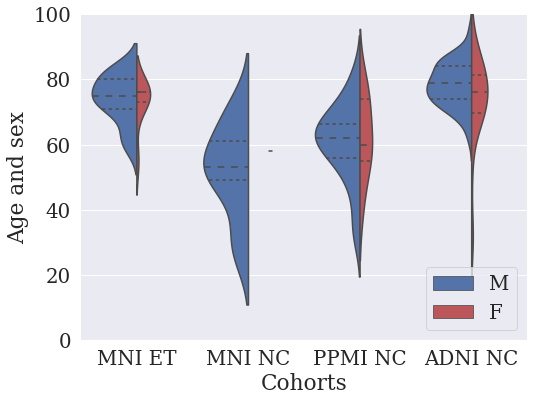

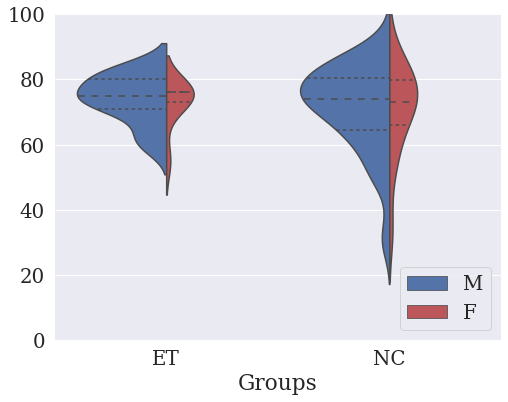

In [7]:
# visualziation for cohort age/sex distributions
#from matplotlib import pyplot
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.8)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

GROUP_ORDER=['MNI ET','MNI NC','PPMI NC','ADNI NC']; SEX_ORDER=['M','F']; 
LIM_AGE=(0, 100); LIM_CNT=(0, 40); 

distr_vis_df = matched_des_df.copy()
distr_vis_df.loc[:,'cohort group']=distr_vis_df.loc[:,'cohort']+' '+distr_vis_df.loc[:,'group'];

# Nested violinplot for cohort-group pairs distribution
f1, ax1 = plt.subplots(figsize=(8, 6))
ax1=sns.violinplot(data=distr_vis_df, x="cohort group", y="age", hue="sex",
                   split=True, inner="quartile",  scale='count', bw='silverman', orient='v',
                   order=GROUP_ORDER, hue_order=SEX_ORDER, 
                   linewidth=1.5, saturation=0.85, palette= ["b", "r"])
sns.despine(left=True)
ax1.set(ylim=LIM_AGE); 
ax1.set(xlabel="Cohorts"); 
ax1.set(ylabel="Age and sex"); 
plt.legend(loc='lower right')
#f1.suptitle('Dataset distribution after Matching',fontsize=24)
f1.savefig(fig_sv_dir / "cohort_afterMatching.jpg", dpi=300)

# Nested violinplot for group pairs distribution
f2, ax2 = plt.subplots(figsize=(8, 6))

ax2=sns.violinplot(data=distr_vis_df, x="group", y="age", hue="sex",
                          split=True, inner="quartile",  scale='count', bw='silverman', orient='v',
                          order=['ET', 'NC'], hue_order=SEX_ORDER, 
                          linewidth=1.5, saturation=0.85, palette= ["b", "r"])
sns.despine(left=True)
ax2.set(ylim=LIM_AGE); 
ax2.set(xlabel="Groups"); 
ax2.set(ylabel=""); 
plt.legend(loc='lower right')
#f2.suptitle('Group distribution after matching',fontsize=24)
f2.savefig(fig_sv_dir / "group_afterMatching.jpg", dpi=300)

# Below is the preparation for VBM analysis

In [8]:
# Saving subject list for VBM analysis
vbm_subject_list_file = data_dir/"matched_subjectList_vbm.csv"
# save matching results for latter analysis
display(matched_des_df)
matched_des_df.to_csv(matched_des_file)
display(matched_DKT_df)
matched_DKT_df.to_csv(matched_DKT_file)

# output the matched subject list
matched_des_df.index=[x.replace('_','-') for x in matched_des_df.index ]
matched_des_df=matched_des_df.sort_index() # sort_values(by=['group','cohort'])
sub_matched_df=matched_des_df[['age','sex','group','cohort','eTIV']].copy()
sub_matched_df.to_csv(vbm_subject_list_file)
#need to add "subject" to the first column name line.

,age,sex,site,group,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus_Proper,Left_Caudate,...,maget_score,Cerebellum_White_Matter,Cerebellum_Cortex,cerebellumVol,InfraTentorialVol,male,cohort,is_mni,is_ppmi,is_adni
sub_100S4511,70,M,adni_100,NC,11427.6,424.4,15911.9,55331.8,6600.8,3211.9,...,2,31457.0,109479.2,140936.2,587664.415344,1,ADNI,0,0,1
sub_130S4343,83,M,adni_130,NC,10845.4,548.5,13456.3,45573.4,5896.1,3676.7,...,3,27066.9,92216.6,119283.5,592246.225723,1,ADNI,0,0,1
sub_002S4225,70,M,adni_002,NC,23852.7,796.2,16486.6,54874.6,7387.1,3784.2,...,3,31937.6,110458.2,142395.8,748281.968552,1,ADNI,0,0,1
sub_041S4083,85,M,adni_041,NC,31389.4,961.4,14308.6,57239.2,6839.4,3815.4,...,3,28797.1,117169.7,145966.8,713409.711153,1,ADNI,0,0,1
sub_032S4429,79,M,adni_032,NC,24074.8,652.9,10650.4,44728.0,6142.3,4306.2,...,3,21895.7,90226.2,112121.9,605365.562410,1,ADNI,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub_5700,65,M,mni_001,ET,9312.9,666.8,13890.8,52756.7,7177.5,3617.3,...,3,27363.6,107057.3,134420.9,531060.495850,1,MNI,1,0,0
sub_7000,60,M,mni_001,ET,8617.5,478.7,15254.4,54279.0,6604.6,3851.4,...,3,29375.1,110385.3,139760.4,542491.804010,1,MNI,1,0,0
sub_7400,73,F,mni_001,ET,10308.7,271.7,12815.0,45502.6,6363.5,2973.3,...,3,24583.4,92513.7,117097.1,546616.108254,0,MNI,1,0,0
sub_7800,61,M,mni_001,ET,6326.8,544.9,13014.1,50390.7,5420.6,2944.2,...,3,25626.6,100291.5,125918.1,436383.428566,1,MNI,1,0,0


,age,sex,site,group,Left_Lateral_Ventricle,Left_Inf_Lat_Vent,Left_Cerebellum_White_Matter,Left_Cerebellum_Cortex,Left_Thalamus_Proper,Left_Caudate,...,maget_score,Cerebellum_White_Matter,Cerebellum_Cortex,cerebellumVol,InfraTentorialVol,male,cohort,is_mni,is_ppmi,is_adni
sub_100S4511,70,M,adni_100,NC,11427.6,424.4,15911.9,55331.8,6600.8,3211.9,...,2,31457.0,109479.2,140936.2,587664.415344,1,ADNI,0,0,1
sub_130S4343,83,M,adni_130,NC,10845.4,548.5,13456.3,45573.4,5896.1,3676.7,...,3,27066.9,92216.6,119283.5,592246.225723,1,ADNI,0,0,1
sub_002S4225,70,M,adni_002,NC,23852.7,796.2,16486.6,54874.6,7387.1,3784.2,...,3,31937.6,110458.2,142395.8,748281.968552,1,ADNI,0,0,1
sub_041S4083,85,M,adni_041,NC,31389.4,961.4,14308.6,57239.2,6839.4,3815.4,...,3,28797.1,117169.7,145966.8,713409.711153,1,ADNI,0,0,1
sub_032S4429,79,M,adni_032,NC,24074.8,652.9,10650.4,44728.0,6142.3,4306.2,...,3,21895.7,90226.2,112121.9,605365.562410,1,ADNI,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sub_5700,65,M,mni_001,ET,9312.9,666.8,13890.8,52756.7,7177.5,3617.3,...,3,27363.6,107057.3,134420.9,531060.495850,1,MNI,1,0,0
sub_7000,60,M,mni_001,ET,8617.5,478.7,15254.4,54279.0,6604.6,3851.4,...,3,29375.1,110385.3,139760.4,542491.804010,1,MNI,1,0,0
sub_7400,73,F,mni_001,ET,10308.7,271.7,12815.0,45502.6,6363.5,2973.3,...,3,24583.4,92513.7,117097.1,546616.108254,0,MNI,1,0,0
sub_7800,61,M,mni_001,ET,6326.8,544.9,13014.1,50390.7,5420.6,2944.2,...,3,25626.6,100291.5,125918.1,436383.428566,1,MNI,1,0,0


# Select normalized subjects T1 images and masks from fRMIPrep outputs based on the matched subject lists and apply the mask to obtain the brain images.

In [8]:
# preparing folders
import os
import shutil

image_folder =  Path("/scratch/Augmented_VBM")
mni_image_dir = image_folder/"mni"
ppmi_image_dir = image_folder/"ppmi"
adni_image_dir = image_folder/"adni"
brain_mask_str = "_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain_mask.nii.gz"
T1_str = "_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz"
masked_str = "_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_brain.nii.gz"

# maksing a list of subjects
def masking_T1_nii(sub_list, data_dir):
    from nipype.interfaces import fsl
    import time
    out_list=[]
    t0=time.time()
    for x_ in sub_list:
        sub_str=x_;
        IN_IMAGE   = Path(data_dir / (sub_str+T1_str));
        MASK_IMG   = Path(data_dir / (sub_str+brain_mask_str));
        MASKed_IMG = Path(data_dir / (sub_str+masked_str));
        mask = fsl.ApplyMask(
            in_file  =IN_IMAGE,
            out_file =MASKed_IMG,
            mask_file=MASK_IMG)
        mask.run()
        out_list.append(MASKed_IMG)
    print('masking takes: ', time.time()-t0 )
    return out_list

In [10]:
# the matched MNI cohort:
mni_left_list=sub_matched_df[sub_matched_df['cohort']=='MNI'].sort_index().index
print('MNI left ', len(mni_left_list),' :')
print(mni_left_list)

# uncomment to do the file operations
# masking (will be use latter)
# mni_masked_list=masking_T1_nii(mni_left_list, mni_image_dir)
#for x_ in mni_masked_list:
#    file_=str(x_)
#    # unziping
#    os.system('gunzip --keep ' + file_)
#    # copy back
#    shutil.copy(file_[:-3], file_[:23]+file_[28:-3])

## extra code to rename (remove session names)
#for x_ in mni_left_list:
#    masked_file=str(Path(mni_image_dir / (x_+"_ses-1_run-1_space-MNI152NLin2009cAsym_res-2_desc-brain.nii")))
#    # copy back
#    shutil.copy(masked_file, masked_file[:23]+x_+masked_file[41:-15]+'_desc-preproc_brain.nii')
print("ET subjects: ")
sub_matched_df[sub_matched_df['group']=='ET'].sort_index().index

MNI left  50  :
Index(['sub-0016', 'sub-0041', 'sub-0044', 'sub-0053', 'sub-0057', 'sub-0061',
       'sub-0062', 'sub-0067', 'sub-0072', 'sub-0080', 'sub-0081', 'sub-0082',
       'sub-0085', 'sub-0100', 'sub-0104', 'sub-0108', 'sub-0110', 'sub-0117',
       'sub-0119', 'sub-0130', 'sub-0134', 'sub-0139', 'sub-0140', 'sub-0141',
       'sub-0142', 'sub-0143', 'sub-0146', 'sub-0147', 'sub-0178', 'sub-1012',
       'sub-1120', 'sub-1160', 'sub-1230', 'sub-1310', 'sub-1340', 'sub-1690',
       'sub-1890', 'sub-1920', 'sub-2400', 'sub-3600', 'sub-3700', 'sub-3900',
       'sub-4200', 'sub-4300', 'sub-4700', 'sub-5700', 'sub-7000', 'sub-7400',
       'sub-7800', 'sub-8000'],
      dtype='object')
ET subjects: 


Index(['sub-0016', 'sub-0061', 'sub-0081', 'sub-0119', 'sub-0134', 'sub-0139',
       'sub-0140', 'sub-0141', 'sub-0142', 'sub-0143', 'sub-0146', 'sub-0147',
       'sub-0178', 'sub-1012', 'sub-1120', 'sub-1160', 'sub-1230', 'sub-1310',
       'sub-1340', 'sub-1690', 'sub-1890', 'sub-1920', 'sub-2400', 'sub-3600',
       'sub-3700', 'sub-3900', 'sub-4200', 'sub-4300', 'sub-4700', 'sub-5700',
       'sub-7000', 'sub-7400', 'sub-7800', 'sub-8000'],
      dtype='object')

In [11]:
# the matched PPMI cohort:
ppmi_left_list=sub_matched_df[sub_matched_df['cohort']=='PPMI'].sort_index().index
print('PPMI left ', len(ppmi_left_list),' :')
print(ppmi_left_list)

# uncomment to do the file operations
# masking 
#ppmi_masked_list=masking_T1_nii(ppmi_left_list, ppmi_image_dir)
# unzip 
#for x_ in ppmi_masked_list:
#    file_=str(x_)
#    os.system('gunzip --keep ' + file_)
#    # copy back
#    shutil.copy(file_[:-3], file_[:23]+file_[28:-3])

PPMI left  41  :
Index(['sub-3004', 'sub-3011', 'sub-3013', 'sub-3151', 'sub-3157', 'sub-3160',
       'sub-3172', 'sub-3277', 'sub-3310', 'sub-3351', 'sub-3358', 'sub-3390',
       'sub-3515', 'sub-3517', 'sub-3518', 'sub-3519', 'sub-3523', 'sub-3525',
       'sub-3527', 'sub-3555', 'sub-3563', 'sub-3571', 'sub-3611', 'sub-3614',
       'sub-3635', 'sub-3750', 'sub-3756', 'sub-3759', 'sub-3768', 'sub-3779',
       'sub-3804', 'sub-3806', 'sub-3807', 'sub-3809', 'sub-3816', 'sub-3854',
       'sub-3859', 'sub-4018', 'sub-4067', 'sub-4085', 'sub-4139'],
      dtype='object')


In [12]:
# the matched ADNI cohort:
adni_left_list=sub_matched_df[sub_matched_df['cohort']=='ADNI'].sort_index().index
print('ADNI left ', len(adni_left_list),' :')
print(', '.join(adni_left_list))

# uncomment to do the file operations
# masking 
#adni_masked_list=masking_T1_nii(adni_left_list, adni_image_dir)
#for x_ in adni_masked_list:
#    file_=str(x_)
#    # unzip 
#    os.system('gunzip --keep ' + file_)
#    # copy back
#    shutil.copy(file_[:-3], file_[:23]+file_[28:-3])

ADNI left  120  :
sub-002S0295, sub-002S4225, sub-003S0907, sub-003S4288, sub-003S4350, sub-003S4872, sub-005S0553, sub-005S0602, sub-006S0731, sub-006S4150, sub-007S1206, sub-007S4620, sub-009S0842, sub-009S4337, sub-010S4345, sub-011S4120, sub-011S4222, sub-011S4278, sub-012S4643, sub-013S4579, sub-014S0519, sub-014S4093, sub-014S4577, sub-016S4638, sub-016S4951, sub-018S0055, sub-018S4257, sub-020S1288, sub-021S4276, sub-022S0096, sub-022S4266, sub-023S0058, sub-023S4164, sub-023S4448, sub-024S0985, sub-027S0074, sub-027S0120, sub-029S0824, sub-029S4585, sub-031S4021, sub-031S4218, sub-032S0479, sub-032S4348, sub-032S4429, sub-032S4921, sub-033S0734, sub-033S0741, sub-033S4176, sub-033S4179, sub-035S0156, sub-035S4464, sub-036S4878, sub-037S0303, sub-037S4071, sub-037S4308, sub-041S4014, sub-041S4041, sub-041S4083, sub-041S4427, sub-068S0127, sub-068S0210, sub-070S4856, sub-072S0315, sub-072S4391, sub-073S0089, sub-073S4393, sub-073S4552, sub-073S4762, sub-073S4795, sub-082S4090, su